# Déployez un modèle dans le cloud



In [ ]:
# L'exécution de cette cellule démarre l'application Spark

In [ ]:
%%info

## Import des librairies

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT 
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.sql.types import StringType

## Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [7]:
PATH = 's3://oc-p8-data'
PATH_Data = PATH+'/test_S3'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 8/P8_Mode_opératoire
PATH_Data:   /Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 8/P8_Mode_opératoire/data/Test_sample300
PATH_Result: /Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 8/P8_Mode_opératoire/data/Results


## Traitement des données
### Chargement des données

In [11]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [ ]:
images.show(5)

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [12]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------------------------------------------------------------------------------------------+--------------+
|path                                                                                                                            |label         |
+--------------------------------------------------------------------------------------------------------------------------------+--------------+
|file:/Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 8/P8_Mode_opératoire/data/Test_sample300/Watermelon/r_48_100.jpg   |Watermelon    |
|file:/Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 8/P8_Mode_opératoire/data/Test_sample300/Pineapple Mini/7_100.jpg  |Pineapple Mini|
|file:/Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 8

## Préparation du modèle

In [13]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [14]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [15]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [16]:
brodcast_weights = sc.broadcast(new_model.get_weights())

In [17]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

### Définition du processus de chargement des images et application <br/>de leur featurisation à travers l'utilisation de pandas UDF

In [18]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Users/oceaneyouyoutte/miniconda3/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### Exécution des actions d'extraction de features

In [15]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [19]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [20]:
print(PATH_Result)

/Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 8/P8_Mode_opératoire/data/Results


<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [21]:
features_df.write.mode("overwrite").parquet(PATH_Result)

1/1 [==============================] - 1s 550ms/step===========>  (19 + 1) / 20]


## Chargement des données enregistrées et validation du résultat

In [22]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [23]:
df.head()

,path,label,features
0,file:/Users/oceaneyouyoutte/Desktop/Data Scien...,Cauliflower,"[0.0, 1.5177789, 1.2785709, 0.0, 0.0, 0.0, 0.0..."
1,file:/Users/oceaneyouyoutte/Desktop/Data Scien...,Pineapple,"[0.0, 3.23245, 0.6239703, 0.0, 0.0, 0.03144627..."
2,file:/Users/oceaneyouyoutte/Desktop/Data Scien...,Potato White,"[0.004783027, 0.0, 0.0, 0.0, 0.053286135, 0.02..."
3,file:/Users/oceaneyouyoutte/Desktop/Data Scien...,Apple Red 1,"[0.004372801, 0.030688763, 0.058095757, 0.0, 0..."
4,file:/Users/oceaneyouyoutte/Desktop/Data Scien...,Apple Red Yellow 1,"[0.12546742, 0.046856567, 0.0, 0.0, 0.01564947..."


In [24]:
df.loc[0,'features'].shape

(1280,)

## Réduction de dimension - ACP

In [26]:
# Les données images sont converties au format vecteur dense
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
vectorized_df = features_df.withColumn('image_vec', ud_f('features'))
vectorized_df.show(5)

1/1 [==============================] - 0s 473ms/step                (0 + 1) / 1]


+--------------------+------------------+--------------------+--------------------+
|                path|             label|            features|           image_vec|
+--------------------+------------------+--------------------+--------------------+
|file:/Users/ocean...|       Cauliflower|[0.0, 1.5177789, ...|[0.0,1.5177788734...|
|file:/Users/ocean...|         Pineapple|[0.0, 3.23245, 0....|[0.0,3.2324500083...|
|file:/Users/ocean...|      Potato White|[0.004783027, 0.0...|[0.00478302687406...|
|file:/Users/ocean...|       Apple Red 1|[0.004372801, 0.0...|[0.00437280116602...|
|file:/Users/ocean...|Apple Red Yellow 1|[0.12546742, 0.04...|[0.12546741962432...|
+--------------------+------------------+--------------------+--------------------+
only showing top 5 rows



In [27]:
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='image_vec',
                              outputCol='feats_scaled')
std = standardizer.fit(vectorized_df)
features_df_scaled = std.transform(vectorized_df)

1/1 [==============================] - 1s 553ms/step===========>  (19 + 1) / 20]


In [28]:
features_df_scaled.printSchema()
features_df_scaled.show(5) 

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- image_vec: vector (nullable = true)
 |-- feats_scaled: vector (nullable = true)



1/1 [==============================] - 0s 474ms/step                (0 + 1) / 1]


+--------------------+------------------+--------------------+--------------------+--------------------+
|                path|             label|            features|           image_vec|        feats_scaled|
+--------------------+------------------+--------------------+--------------------+--------------------+
|file:/Users/ocean...|       Cauliflower|[0.0, 1.5177789, ...|[0.0,1.5177788734...|[-0.7742883467037...|
|file:/Users/ocean...|         Pineapple|[0.0, 3.23245, 0....|[0.0,3.2324500083...|[-0.7742883467037...|
|file:/Users/ocean...|      Potato White|[0.004783027, 0.0...|[0.00478302687406...|[-0.7651209686269...|
|file:/Users/ocean...|       Apple Red 1|[0.004372801, 0.0...|[0.00437280116602...|[-0.7659072268399...|
|file:/Users/ocean...|Apple Red Yellow 1|[0.12546742, 0.04...|[0.12546741962432...|[-0.5338114892038...|
+--------------------+------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [30]:
# nombre de features par image
first_row = features_df_scaled.select("features").take(1)
print(" le nombre de features par image est de: ", len(first_row[0][0]))

 le nombre de features par image est de:  1280


1/1 [==============================] - 0s 462ms/step


In [31]:
pca = PCA(k=300, inputCol="feats_scaled", outputCol="pca_feat")
modelpca = pca.fit(features_df_scaled)

1/1 [==============================] - 1s 571ms/step               (0 + 1) / 20]
23/07/28 22:08:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
1/1 [==============================] - 1s 551ms/step===========>  (19 + 1) / 20]
23/07/28 22:09:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


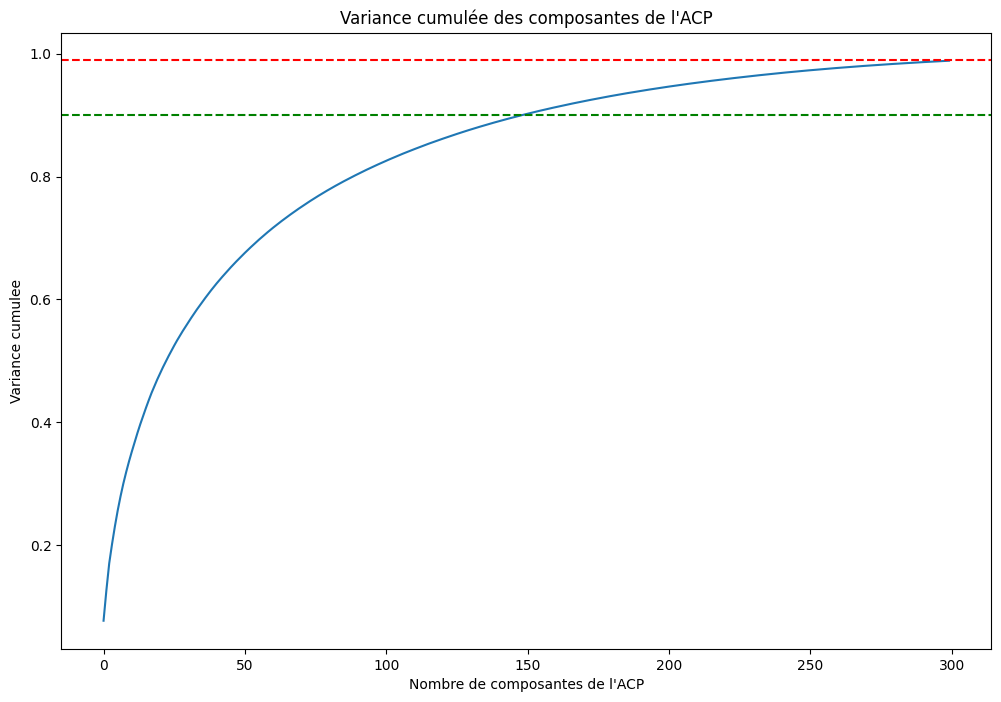

In [32]:
sum_var_pca = np.cumsum(modelpca.explainedVariance)

plt.figure(figsize=(12,8))
plt.title("Variance cumulée des composantes de l'ACP")
plt.xlabel("Nombre de composantes de l'ACP")
plt.ylabel("Variance cumulee")

plt.plot(range(len(sum_var_pca)), sum_var_pca)
plt.axhline(y=0.99, color='r', linestyle='--')
plt.axhline(y=0.9, color='g', linestyle='--')

plt.show()

In [33]:
sum_var_pca[200]

0.9463885350462244

In [34]:
pca_opti = PCA(k=200, inputCol="feats_scaled", outputCol="pca_feat")
modelpca_opti = pca_opti.fit(features_df_scaled)

1/1 [==============================] - 1s 553ms/step===========>  (19 + 1) / 20]


In [35]:
transformed = modelpca_opti.transform(features_df_scaled)

In [36]:
transformed.show(5)

23/07/28 22:11:08 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|                path|             label|            features|           image_vec|        feats_scaled|            pca_feat|
+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|file:/Users/ocean...|       Cauliflower|[0.0, 1.5177789, ...|[0.0,1.5177788734...|[-0.7742883467037...|[7.44918994780901...|
|file:/Users/ocean...|         Pineapple|[0.0, 3.23245, 0....|[0.0,3.2324500083...|[-0.7742883467037...|[14.3105529155911...|
|file:/Users/ocean...|      Potato White|[0.004783027, 0.0...|[0.00478302687406...|[-0.7651209686269...|[-2.0633113579790...|
|file:/Users/ocean...|       Apple Red 1|[0.004372801, 0.0...|[0.00437280116602...|[-0.7659072268399...|[-4.1465544434269...|
|file:/Users/ocean...|Apple Red Yellow 1|[0.12546742, 0.04...|[0.12546741962432...|[-0.5338114892038...|[-13.617877556

1/1 [==============================] - 1s 556ms/step


In [37]:
df_final = transformed.select('path', 'label', 'pca_feat')

In [38]:
df_final.show(5)

23/07/28 22:11:13 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
1/1 [==============================] - 0s 470ms/step                (0 + 1) / 1]


+--------------------+------------------+--------------------+
|                path|             label|            pca_feat|
+--------------------+------------------+--------------------+
|file:/Users/ocean...|       Cauliflower|[7.44918994780901...|
|file:/Users/ocean...|         Pineapple|[14.3105529155911...|
|file:/Users/ocean...|      Potato White|[-2.0633113579790...|
|file:/Users/ocean...|       Apple Red 1|[-4.1465544434269...|
|file:/Users/ocean...|Apple Red Yellow 1|[-13.617877556624...|
+--------------------+------------------+--------------------+
only showing top 5 rows



In [40]:
# Sauvegarde des donnees au format parquet dans S3

df_final.write.mode('overwrite').parquet(PATH_Result)

23/07/28 22:11:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
1/1 [==============================] - 1s 551ms/step===========>  (19 + 1) / 20]


In [44]:
# sauvegarde en format csv

format_udf = udf(lambda x: str(x), StringType()) 

df_csv = df_final.withColumn('pca_feat', format_udf(col('pca_feat')))

df_csv.write.mode("overwrite").option("delimiter", "\t").option("header","true").csv(PATH_Result + "_acp.csv")

23/07/28 22:17:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
1/1 [==============================] - 0s 357ms/step===========>  (19 + 1) / 20]


### Chargement des données enregistrées et validation du résultat

In [46]:
df_pca = spark.read.parquet(PATH_Result)
df_pca = df_pca.toPandas()
df_pca.head(5)

,path,label,pca_feat
0,file:/Users/oceaneyouyoutte/Desktop/Data Scien...,Rambutan,"[14.952773377616763, -1.441300754340963, -9.76..."
1,file:/Users/oceaneyouyoutte/Desktop/Data Scien...,Watermelon,"[7.142155343192459, -6.882551109760895, -6.660..."
2,file:/Users/oceaneyouyoutte/Desktop/Data Scien...,Cantaloupe 1,"[-5.22411076128093, -6.634907999167829, 1.5608..."
3,file:/Users/oceaneyouyoutte/Desktop/Data Scien...,Pear Stone,"[0.16507039093618242, -11.14088665720186, -6.1..."
4,file:/Users/oceaneyouyoutte/Desktop/Data Scien...,Onion Red Peeled,"[-1.2736609812019115, 0.9276298806338973, -2.8..."
